In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
fpath_eddy = '/gscratch/jisao/mclaret/GL64/Juillet/'
f = h5py.File(fpath_eddy + 'eddy_tracks.mat')

# Arrange data into a list of dictionaries
data = f['tracks']            # relevant variables
varnames = list(f['tracks'])  # variable names
ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

tracks = []                   # initialize list of eddy tracks

# add dictionaries for each variable to the corresponding eddy index (0 - N-1)
for itrack in range(ntracks):
    variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
    for var in varnames:
        # go through each variable
        if var[0:6] == 'shapes':
            # translate shapes data to list of numpy arrays (one array for each time step)
            coordinates = []                             # initialize list of coordinates
            numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
            # each timestep has its own hdf5 object reference, so append each step to a list
            for step in range(numSteps):
                coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                coordinates.append(coords)
            variables[var] = coordinates
        else:
            # translate data from hdf5 object reference to numpy array
            variables[var] = np.array(f[data[var][itrack,0]][(0)])
    tracks.append(variables)
    
print('Number of eddies:', len(tracks))

Number of eddies: 111


In [3]:
lifetime = 0           # lifetime to keep (in hours)
ntracks = len(tracks)  # number of eddies
cyclones = []          # list to hold cyclonic eddies
anticyclones = []      # list to hold anticyclonic eddies
nIssue = 0
wIssue = []

for i, track in enumerate(tracks):
    #timesteps = track['step'][-1] - track['step'][0] + 1
    if track['type'][0] == 1.:
        # add to list of cyclonic eddies
        cyclones.append(track)
    if track['type'][0] == -1.:
        # add to list of cyclonic eddies
        anticyclones.append(track)
print('num cyclones:', len(cyclones))
print('num anticyclones:', len(anticyclones))

num cyclones: 53
num anticyclones: 58


In [4]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculates distance between two geographic coordinates (po1, pos2)"""
    R = 6373.                                      # radius of Earth (in km)
    coords = np.float64([lon1, lat1, lon2, lat2])  # ensure coords are not integers
    lon1, lat1, lon2, lat2 = np.radians(coords)    # convert to radians
    
    dlon = lon2 - lon1  # distance btwn longitudes
    dlat = lat2 - lat1  # distance btwn latitudes
    
    # haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R*c

Anticyclones
mean lifetime:       100.6 hrs
shortest lifetime:     1.0 hrs
longest lifetime:    371.0 hrs
mean distance:        66.0 km
shortest distance:     0.0 km
furthest distance:   443.4 km


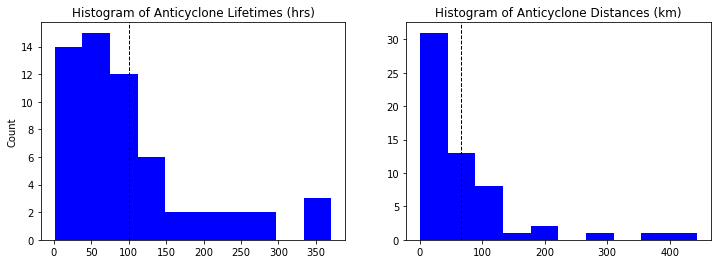

In [5]:
lftmAnticyclones = []      # initialize list of lifetimes
lftmMeanAnticyclones = 0   # variable to calculate mean lifetime
lftmHiAnticyclones = 0     # longest lifetime
lftmLoAnticyclones = 500   # shortest lifetime
distAnticyclones = []      # initialize list of distances
distMeanAnticyclones = 0   # variable to calculate mean distance
distHiAnticyclones = 0     # furthest distance
distLoAnticyclones = 1000  # shortest distance

# loop through all cyclones
for i, track in enumerate(anticyclones):
    lftm = track['step'][-1] - track['step'][0] + 1  # calculate lifetime
    lftmAnticyclones.append(lftm)                        # add to list for histo
    lftmMeanAnticyclones += lftm                         # add to sum for mean
    
    # lifetime highs and lows
    if lftm > lftmHiAnticyclones:
        lftmHiAnticyclones = lftm
    elif lftm < lftmLoAnticyclones:
        lftmLoAnticyclones = lftm
    
    # calculate distance
    dist = 0.
    for i in range(len(track['step'])):
        # sum distances
        currLon = track['x1'][i]
        currLat = track['y1'][i]
        if i > 0:
            dist += haversine(prevLon, prevLat, currLon, currLat)
        prevLon = currLon
        prevLat = currLat
    distAnticyclones.append(dist)  # add to list for histo
    distMeanAnticyclones += dist   # add to sum for mean
    
    # distance highs and lows
    if dist > distHiAnticyclones:
        distHiAnticyclones = dist
    elif dist < distLoAnticyclones:
        distLoAnticyclones = dist
        
# finish mean calculations
lftmMeanAnticyclones /= len(anticyclones)
distMeanAnticyclones /= len(anticyclones)

# print results and plot histogram
print('Anticyclones')
print(f'mean lifetime:{round(lftmMeanAnticyclones, 1):12} hrs')
print(f'shortest lifetime:{lftmLoAnticyclones:8} hrs')
print(f'longest lifetime:{lftmHiAnticyclones:9} hrs')

print(f'mean distance:{round(distMeanAnticyclones,1):12} km')
print(f'shortest distance:{round(distLoAnticyclones,1):8} km')
print(f'furthest distance:{round(distHiAnticyclones,1):8} km')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(lftmAnticyclones, bins=10, color='b')
ax1.axvline(x = lftmMeanAnticyclones, color='k', linewidth=1, linestyle='dashed')
ax1.set_title('Histogram of Anticyclone Lifetimes (hrs)')
ax1.set_ylabel('Count')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(distAnticyclones, bins=10, color='b')
ax2.axvline(x = distMeanAnticyclones, color='k', linewidth=1, linestyle='dashed')
ax2.set_title('Histogram of Anticyclone Distances (km)')
plt.show()

Cyclones
mean lifetime:       148.5 hrs
shortest lifetime:     1.0 hrs
longest lifetime:    371.0 hrs
mean distance:        48.5 km
shortest distance:     0.0 km
furthest distance:   286.4 km


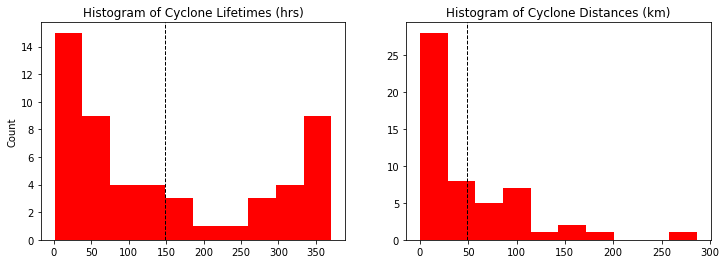

In [6]:
lftmCyclones = []      # initialize list of lifetimes
lftmMeanCyclones = 0   # variable to calculate mean lifetime
lftmHiCyclones = 0     # longest lifetime
lftmLoCyclones = 500   # shortest lifetime
distCyclones = []      # initialize list of distances
distMeanCyclones = 0   # variable to calculate mean distance
distHiCyclones = 0     # furthest distance
distLoCyclones = 1000  # shortest distance

# loop through all cyclones
for i, track in enumerate(cyclones):
    lftm = track['step'][-1] - track['step'][0] + 1  # calculate lifetime
    lftmCyclones.append(lftm)                        # add to list for histo
    lftmMeanCyclones += lftm                         # add to sum for mean
    
    # lifetime highs and lows
    if lftm > lftmHiCyclones:
        lftmHiCyclones = lftm
    elif lftm < lftmLoCyclones:
        lftmLoCyclones = lftm
    
    # calculate distance
    dist = 0.
    for i in range(len(track['step'])):
        # sum distances
        currLon = track['x1'][i]
        currLat = track['y1'][i]
        if i > 0:
            dist += haversine(prevLon, prevLat, currLon, currLat)
        prevLon = currLon
        prevLat = currLat
    distCyclones.append(dist)  # add to list for histo
    distMeanCyclones += dist   # add to sum for mean
    
    # distance highs and lows
    if dist > distHiCyclones:
        distHiCyclones = dist
    elif dist < distLoCyclones:
        distLoCyclones = dist
        
# finish mean calculations
lftmMeanCyclones /= len(cyclones)
distMeanCyclones /= len(cyclones)

# print results and plot histogram
print('Cyclones')
print(f'mean lifetime:{round(lftmMeanCyclones, 1):12} hrs')
print(f'shortest lifetime:{lftmLoCyclones:8} hrs')
print(f'longest lifetime:{lftmHiCyclones:9} hrs')

print(f'mean distance:{round(distMeanCyclones,1):12} km')
print(f'shortest distance:{round(distLoCyclones,1):8} km')
print(f'furthest distance:{round(distHiCyclones,1):8} km')

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(lftmCyclones, bins=10, color='r')
ax1.axvline(x = lftmMeanCyclones, color='k', linewidth=1, linestyle='dashed')
ax1.set_title('Histogram of Cyclone Lifetimes (hrs)')
ax1.set_ylabel('Count')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(distCyclones, bins=10, color='r')
ax2.axvline(x = distMeanCyclones, color='k', linewidth=1, linestyle='dashed')
ax2.set_title('Histogram of Cyclone Distances (km)')
plt.show()

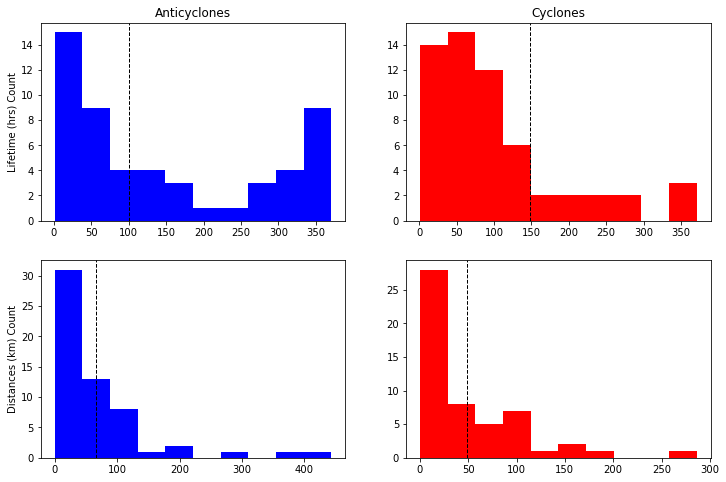

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
ax1.hist(lftmCyclones, bins=10, color='b')
ax1.axvline(x = lftmMeanAnticyclones, color='k', linewidth=1, linestyle='dashed')
ax1.set_title('Anticyclones')
ax1.set_ylabel('Lifetime (hrs) Count')

ax2 = fig.add_subplot(2,2,2)
ax2.hist(lftmAnticyclones, bins=10, color='r')
ax2.axvline(x = lftmMeanCyclones, color='k', linewidth=1, linestyle='dashed')
ax2.set_title('Cyclones')

ax3 = fig.add_subplot(2,2,3)
ax3.hist(distAnticyclones, bins=10, color='b')
ax3.axvline(x = distMeanAnticyclones, color='k', linewidth=1, linestyle='dashed')
ax3.set_ylabel('Distances (km) Count')

ax4 = fig.add_subplot(2,2,4)
ax4.hist(distCyclones, bins=10, color='r')
ax4.axvline(x = distMeanCyclones, color='k', linewidth=1, linestyle='dashed')
plt.show()